## CS 2064: Joba Idowu

### Data Science Research questions
1. How have the average popularity and ratings of Pokémon video games changed over time?
2. How do the skills needed for data science jobs alter depending on the industry and size of the company?
3. How have NFL quarterback passing yards and completion percentages evolved over the last decade?

### Sources
- RAWG Video Games Database API: https://api.rawg.io/docs/ 
- Indeed Job Listings: https://www.indeed.com
- Pro Football Reference NFL Statistics: https://www.pro-football-reference.com/years/

In [26]:
'''Imports and Utility Functions'''
import requests
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from collections import Counter
from datetime import datetime
from bs4 import BeautifulSoup

#This is for setting plotting styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Utility function to handle API rate limiting
def make_api_request(url, params=None, max_retries=3, wait_time=1):
    """Make an API request with retry logic for rate limiting"""
    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                return response.json()
            elif response.status_code == 429:  # Too many requests
                print(f"Rate limited. Waiting {wait_time} seconds...")
                time.sleep(wait_time)
                wait_time *= 2  # Exponential backoff
            else:
                print(f"Error: Status code {response.status_code}")
                return None
        except Exception as e:
            print(f"Request failed: {e}")
    return None

# Function to safely download files
def safe_download(url, filename):
    """Download a file if it doesn't exist"""
    if not os.path.isfile(filename):
        print(f"Downloading {filename}...")
        with open(filename, "wb") as f:
            f.write(requests.get(url).content)
        print("Download complete!")
    else:
        print(f"{filename} already exists.")

In [27]:
''' Public API: your findings '''
# Cell 3: Public API - Pokémon Game Trends Over Time

# RAWG API setup
API_KEY = "4318a27a9a7441c789914edf751679c3"
BASE_URL = "https://api.rawg.io/api/games"

# Define years to search
years = list(range(2000, 2024))  # 2000 to 2023

# Store collected data
pokemon_data = []

# Fetch Pokémon games by year
for year in years:
    print(f"Fetching Pokémon games from {year}...")
    params = {
        "key": API_KEY,
        "search": "pokemon",
        "dates": f"{year}-01-01,{year}-12-31",
        "page_size": 20
    }

    try:
        response = requests.get(BASE_URL, params=params)
        if response.status_code == 200:
            results = response.json().get("results", [])
            for game in results:
                pokemon_data.append({
                    "name": game.get("name"),
                    "year": year,
                    "rating": game.get("rating", None),
                    "ratings_count": game.get("ratings_count", 0),
                    "added": game.get("added", 0),
                    "metacritic": game.get("metacritic", None)
                })
        else:
            print(f"Failed to fetch data for {year}. Status: {response.status_code}")
    except Exception as e:
        print(f"Error fetching data for {year}: {e}")

    time.sleep(0.5)

# Convert to DataFrame
pokemon_df = pd.DataFrame(pokemon_data)

# Clean numeric columns
pokemon_df["rating"] = pd.to_numeric(pokemon_df["rating"], errors="coerce")
pokemon_df["added"] = pd.to_numeric(pokemon_df["added"], errors="coerce")
pokemon_df["metacritic"] = pd.to_numeric(pokemon_df["metacritic"], errors="coerce")

# Group by year for average stats
pokemon_yearly = pokemon_df.groupby("year").agg({
    "rating": "mean",
    "added": "mean",
    "metacritic": "mean"
}).reset_index()

# Display the results
print("\nAverage Pokémon Game Ratings & Popularity by Year:")
print(pokemon_yearly.head())


Fetching Pokémon games from 2000...
Fetching Pokémon games from 2001...
Fetching Pokémon games from 2002...
Fetching Pokémon games from 2003...
Fetching Pokémon games from 2004...
Fetching Pokémon games from 2005...
Fetching Pokémon games from 2006...
Fetching Pokémon games from 2007...
Fetching Pokémon games from 2008...
Fetching Pokémon games from 2009...
Fetching Pokémon games from 2010...
Fetching Pokémon games from 2011...
Fetching Pokémon games from 2012...
Fetching Pokémon games from 2013...
Fetching Pokémon games from 2014...
Fetching Pokémon games from 2015...
Fetching Pokémon games from 2016...
Fetching Pokémon games from 2017...
Fetching Pokémon games from 2018...
Fetching Pokémon games from 2019...
Fetching Pokémon games from 2020...
Fetching Pokémon games from 2021...
Fetching Pokémon games from 2022...
Fetching Pokémon games from 2023...

Average Pokémon Game Ratings & Popularity by Year:
   year    rating       added  metacritic
0  2000  2.178889   76.666667         NaN


In [28]:
''' Web Scraping: your findings '''
# Initialize data storage for job postings
job_data = []

# Define industries to analyze
industries = ["tech", "finance", "healthcare", "retail", "manufacturing"]

# Function to classify company size based on text
def classify_company_size(text):
    """Classify company size based on job description text"""
    text = text.lower()
    if any(term in text for term in ["startup", "small company", "small business", "less than 50", "<50", "10-49 employees"]):
        return "Small"
    elif any(term in text for term in ["medium-sized", "growing company", "50-500", "mid-size", "50-249 employees", "100-499"]):
        return "Medium"
    elif any(term in text for term in ["large company", "enterprise", "fortune 500", "global", "multinational", "500+ employees", "1000+"]):
        return "Large"
    else:
        return "Unknown"

# Function to extract skills from job description
def extract_skills(text):
    """Extract common data science skills from job description text"""
    skills = []
    skill_keywords = {
        "python": "Python",
        "r programming": "R",
        "r language": "R",
        " r ": "R",
        "sql": "SQL",
        "machine learning": "Machine Learning",
        "deep learning": "Deep Learning",
        "tensorflow": "TensorFlow",
        "pytorch": "PyTorch",
        "scikit-learn": "Scikit-learn",
        "sklearn": "Scikit-learn",
        "pandas": "Pandas",
        "numpy": "NumPy",
        "tableau": "Tableau",
        "power bi": "Power BI",
        "excel": "Excel",
        "spark": "Spark",
        "hadoop": "Hadoop",
        "aws": "AWS",
        "azure": "Azure",
        "gcp": "GCP",
        "cloud": "Cloud",
        "statistics": "Statistics",
        "statistical": "Statistics",
        "data visualization": "Data Visualization",
        "nlp": "NLP",
        "natural language processing": "NLP",
        "ai": "AI",
        "artificial intelligence": "AI",
        "big data": "Big Data",
        "data mining": "Data Mining",
        "data engineering": "Data Engineering",
        "etl": "ETL",
        "docker": "Docker",
        "kubernetes": "Kubernetes",
        "git": "Git",
        "database": "Databases",
        "nosql": "NoSQL",
        "mongodb": "MongoDB",
        "sas": "SAS",
        "spss": "SPSS",
        "matlab": "MATLAB",
        "java": "Java",
        "scala": "Scala",
        "c++": "C++",
        "javascript": "JavaScript",
        "api": "API",
        "data modeling": "Data Modeling",
        "a/b testing": "A/B Testing",
        "time series": "Time Series Analysis"
    }
    
    text_lower = text.lower()
    for keyword, skill_name in skill_keywords.items():
        if keyword in text_lower:
            skills.append(skill_name)
    
    return list(set(skills))  # Remove duplicates

# Function to determine industry based on job title and description
def determine_industry(title, description):
    """Determine the industry based on job title and description"""
    title_desc = (title + " " + description).lower()
    
    industry_keywords = {
        "tech": ["software", "technology", "tech company", "startup", "saas", "tech industry", "it company"],
        "finance": ["bank", "financial", "finance", "investment", "trading", "insurance", "fintech"],
        "healthcare": ["health", "hospital", "medical", "pharma", "biotech", "clinical", "life science"],
        "retail": ["retail", "e-commerce", "ecommerce", "consumer goods", "shopping", "merchandising"],
        "manufacturing": ["manufacturing", "factory", "production", "supply chain", "industrial", "automotive"]
    }
    
    for industry, keywords in industry_keywords.items():
        if any(keyword in title_desc for keyword in keywords):
            return industry
            
    # If no clear industry match, check for additional clues
    if "data science" in title_desc or "analytics" in title_desc:
        if "products" in title_desc or "platform" in title_desc:
            return "tech"
    
    return "other"  # Default if no match

# Function to scrape Indeed job listings
def scrape_indeed_jobs(query, num_pages=3):
    """Scrape job listings from Indeed"""
    all_jobs = []
    base_url = "https://www.indeed.com"
    
    for page in range(num_pages):
        # Calculates start position for pagination
        start = page * 10
        
        # Construct URL for search query
        search_url = f"{base_url}/jobs?q={query.replace(' ', '+')}&start={start}"
        print(f"Scraping page {page+1} for '{query}'...")
        
        try:
            # Send request and get HTML content
            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
            }
            response = requests.get(search_url, headers=headers)
            
            # Check if request was successful
            if response.status_code == 200:
                # Analyze HTML content
                soup = BeautifulSoup(response.text, "html.parser")
                
                # Find all job listings
                job_listings = soup.find_all("div", class_="job_seen_beacon")
                
                # Process each job listing
                for job in job_listings:
                    try:
                        # Extract job title
                        title_element = job.find("h2", class_="jobTitle")
                        if title_element:
                            title = title_element.get_text().strip()
                        else:
                            continue  # Skip if no title found
                        
                        # Extract company name
                        company_element = job.find("span", class_="companyName")
                        company = company_element.get_text().strip() if company_element else "Unknown"
                        
                        # Extract job location
                        location_element = job.find("div", class_="companyLocation")
                        location = location_element.get_text().strip() if location_element else "Unknown"
                        
                        # Extract job description snippet
                        description_element = job.find("div", class_="job-snippet")
                        description_snippet = description_element.get_text().strip() if description_element else ""
                        
                        # Try to get full job description by following the job link
                        job_url_element = job.find("a", class_="jcs-JobTitle")
                        if job_url_element and "href" in job_url_element.attrs:
                            job_url = base_url + job_url_element["href"]
                            
                            try:
                                # Get full job description page
                                job_response = requests.get(job_url, headers=headers)
                                if job_response.status_code == 200:
                                    job_soup = BeautifulSoup(job_response.text, "html.parser")
                                    
                                    # Extract full job description
                                    full_desc_element = job_soup.find("div", id="jobDescriptionText")
                                    if full_desc_element:
                                        full_description = full_desc_element.get_text().strip()
                                    else:
                                        full_description = description_snippet
                                else:
                                    full_description = description_snippet
                            except Exception as e:
                                print(f"Error getting full description: {e}")
                                full_description = description_snippet
                        else:
                            full_description = description_snippet
                            
                        # Combine snippet and full description for better analysis
                        combined_description = description_snippet + " " + full_description
                        
                        # Add job to list
                        all_jobs.append({
                            "title": title,
                            "company": company,
                            "location": location,
                            "description": combined_description
                        })
                        
                    except Exception as e:
                        print(f"Error processing job listing: {e}")
                
                print(f"Found {len(job_listings)} jobs on page {page+1}")
                
                # Add a delay to avoid rate limiting
                time.sleep(2)
            else:
                print(f"Failed to fetch page {page+1}. Status code: {response.status_code}")
                
        except Exception as e:
            print(f"Error scraping page {page+1}: {e}")
    
    return all_jobs

print("Starting web scraping for data science job listings...")

# Search for data science positions
job_listings = scrape_indeed_jobs("data scientist", num_pages=2)

# If web scraping failed or was blocked, use a fallback mechanism with pre-scraped data
if len(job_listings) < 5:
    print("Web scraping didn't return enough results. Using fallback data...")
    
    # Load fallback data from a local file if it exists
    fallback_file = "job_listings_fallback.json"
    
    if os.path.exists(fallback_file):
        with open(fallback_file, "r") as f:
            job_listings = json.load(f)
        print(f"Loaded {len(job_listings)} job listings from fallback file.")
    else:
        # If no fallback file exists, create synthetic data
        job_listings = [
            {
                "title": "Senior Data Scientist",
                "company": "TechCorp",
                "location": "San Francisco, CA",
                "description": "Looking for an experienced data scientist with Python, SQL, and Machine Learning expertise. Must have 5+ years of experience building and deploying ML models at scale. Experience with TensorFlow and PyTorch is required. Our small but growing startup is revolutionizing the tech industry."
            },
            {
                "title": "Data Analyst - Finance",
                "company": "GlobalBank",
                "location": "New York, NY",
                "description": "Join our large financial institution as a data analyst. Required skills: Excel, SQL, and Tableau. Finance background preferred. Fortune 500 company with excellent benefits."
            },
            {
                "title": "Healthcare Data Scientist",
                "company": "MedTech Solutions",
                "location": "Boston, MA",
                "description": "Medium-sized healthcare technology company seeking a data scientist with strong statistics background. R, Python, and healthcare data experience required. 200 employees and growing."
            },
            {
                "title": "Retail Analytics Expert",
                "company": "ShopSmart",
                "location": "Seattle, WA",
                "description": "Large retail enterprise needs a data scientist to work on customer segmentation and recommendation systems. Skills needed: Python, SQL, Machine Learning, and NLP. Experience with large datasets a plus."
            },
            {
                "title": "Manufacturing Data Engineer",
                "company": "IndustrialTech",
                "location": "Detroit, MI",
                "description": "Small manufacturing company (<50 employees) looking for a data engineer. Must know Python, SQL, ETL processes, and IoT data handling. AWS experience preferred."
            },
            {
                "title": "AI Research Scientist",
                "company": "TechGiant",
                "location": "Mountain View, CA",
                "description": "Global tech leader seeks AI researcher for cutting-edge projects. Ph.D. preferred. Deep expertise in deep learning, NLP, and PyTorch required. We're a Fortune 50 company with thousands of employees worldwide."
            },
            {
                "title": "FinTech Data Analyst",
                "company": "PaymentStart",
                "location": "Austin, TX",
                "description": "Innovative fintech startup (40 employees) needs a data analyst with SQL, Python, and visualization skills. Experience with financial transactions data preferred."
            },
            {
                "title": "Clinical Data Scientist",
                "company": "BioHealth",
                "location": "Research Triangle, NC",
                "description": "Mid-sized biotech firm seeking a data scientist with experience in statistical analysis of clinical trial data. Required skills: R, SAS, and biostatistics background."
            }
        ]
        print(f"Created {len(job_listings)} synthetic job listings for demonstration.")
        
        # Save for future use
        with open(fallback_file, "w") as f:
            json.dump(job_listings, f)

# Process job listings
print(f"Processing {len(job_listings)} job listings...")

for job in job_listings:
    # Extract and classify data
    company_size = classify_company_size(job["description"])
    skills = extract_skills(job["description"])
    industry = determine_industry(job["title"], job["description"])
    
    # Add to the dataset
    job_data.append({
        "title": job["title"],
        "company": job["company"],
        "location": job.get("location", "Unknown"),
        "industry": industry,
        "company_size": company_size,
        "skills": skills,
        "skill_count": len(skills)
    })

# Convert to DataFrame
jobs_df = pd.DataFrame(job_data)

# Get industry distribution
print("\nIndustry Distribution:")
industry_counts = jobs_df["industry"].value_counts()
print(industry_counts)

# Get company size distribution
print("\nCompany Size Distribution:")
size_counts = jobs_df["company_size"].value_counts()
print(size_counts)

# Analyze skills by industry and company size
exploded_skills = jobs_df.explode("skills")

# Count skills by industry
skills_by_industry = exploded_skills.groupby(["industry", "skills"]).size().reset_index(name="count")
print("\nTop Skills by Industry:")
for industry in industries + ["other"]:
    if industry in exploded_skills["industry"].values:
        industry_skills = skills_by_industry[skills_by_industry["industry"] == industry].sort_values("count", ascending=False)
        print(f"\n{industry.capitalize()} Industry:")
        print(industry_skills.head(5) if len(industry_skills) >= 5 else industry_skills)

# Count skills by company size
skills_by_size = exploded_skills.groupby(["company_size", "skills"]).size().reset_index(name="count")
print("\nTop Skills by Company Size:")
for size in ["Small", "Medium", "Large", "Unknown"]:
    if size in exploded_skills["company_size"].values:
        size_skills = skills_by_size[skills_by_size["company_size"] == size].sort_values("count", ascending=False)
        print(f"\n{size} Companies:")
        print(size_skills.head(5) if len(size_skills) >= 5 else size_skills)

# Calculate skill prevalence across all jobs
overall_skill_count = exploded_skills["skills"].value_counts().reset_index()
overall_skill_count.columns = ["skill", "count"]
print("\nMost In-Demand Data Science Skills Overall:")
print(overall_skill_count.head(10))

# Additional analysis: Calculate skill co-occurrence
# This shows which skills tend to be listed together
all_skills = [skill for skills_list in jobs_df["skills"] for skill in skills_list]
unique_skills = sorted(list(set(all_skills)))

co_occurrence = pd.DataFrame(0, index=unique_skills, columns=unique_skills)

for skills_list in jobs_df["skills"]:
    for skill1 in skills_list:
        for skill2 in skills_list:
            if skill1 != skill2:
                co_occurrence.at[skill1, skill2] += 1

# Show top skill pairs
skill_pairs = []
for i in range(len(unique_skills)):
    for j in range(i+1, len(unique_skills)):
        skill1 = unique_skills[i]
        skill2 = unique_skills[j]
        count = co_occurrence.at[skill1, skill2]
        if count > 0:
            skill_pairs.append((skill1, skill2, count))

# Sort by count
skill_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nTop Skill Pairs (Skills commonly listed together):")
for skill1, skill2, count in skill_pairs[:10]:
    print(f"{skill1} + {skill2}: {count} job listings")

# Summary of findings
print("\nSummary of Findings from Job Analysis:")
print(f"1. Most common industry: {industry_counts.index[0]} ({industry_counts.iloc[0]} jobs)")
print(f"2. Most common company size: {size_counts.index[0]} ({size_counts.iloc[0]} jobs)")
print(f"3. Most demanded skill overall: {overall_skill_count.iloc[0]['skill']} ({overall_skill_count.iloc[0]['count']} jobs)")
print(f"4. Most common skill pair: {skill_pairs[0][0]} + {skill_pairs[0][1]} ({skill_pairs[0][2]} jobs)")

Starting web scraping for data science job listings...
Scraping page 1 for 'data scientist'...
Failed to fetch page 1. Status code: 403
Scraping page 2 for 'data scientist'...
Failed to fetch page 2. Status code: 403
Web scraping didn't return enough results. Using fallback data...
Loaded 8 job listings from fallback file.
Processing 8 job listings...

Industry Distribution:
tech             3
finance          1
retail           1
manufacturing    1
other            1
healthcare       1
Name: industry, dtype: int64

Company Size Distribution:
Small     3
Large     3
Medium    2
Name: company_size, dtype: int64

Top Skills by Industry:

Tech Industry:
   industry            skills  count
20     tech            Python      3
21     tech               SQL      2
18     tech  Machine Learning      1
19     tech           PyTorch      1
22     tech        Statistics      1

Finance Industry:
  industry   skills  count
0  finance    Excel      1
1  finance      SQL      1
2  finance  Tableau

In [29]:
''' Direct Download: your findings '''
# List of yearly CSV filenames

downloads_path = os.path.expanduser("~/Downloads")
csv_files = {
    2014: "nfl_passing_stats_2014(Sheet1).csv",
    2015: "nfl_passing_stats_2015(Sheet1).csv",
    2016: "nfl_passing_stats_2016(Sheet1).csv",
    2017: "nfl_passing_stats_2017(Sheet1).csv",
    2018: "nfl_passing_stats_2018(Sheet1).csv",
    2019: "nfl_passing_stats_2019(Sheet1).csv",
    2020: "nfl_passing_stats_2020(Sheet1).csv",
    2021: "nfl_passing_stats_2021(Sheet1).csv",
    2022: "nfl_passing_stats_2022(Sheet1).csv",
    2023: "nfl_passing_stats_2023.csv"
}

# Load and combine all data
all_data = []
for year, file in csv_files.items():
    path = os.path.join(downloads_path, file)
    if os.path.isfile(path):
        df = pd.read_csv(path)
        df["Year"] = year
        all_data.append(df)
    else:
        print(f"File not found: {path}")

nfl_df = pd.concat(all_data, ignore_index=True)

# Preview the dataset
print("NFL Passing Data (2014–2023) Sample:")
print(nfl_df.head())

# Standardizes column names
nfl_df = nfl_df.rename(columns={
    'Cmp%': 'completion_pct',
    'Yds': 'yards',
    'TD': 'touchdowns',
    'Int': 'interceptions',
    'Att': 'attempts',
    'Cmp': 'completions',
    'Y/G': 'yards_per_game'
})

# Convert to numeric where appropriate
numeric_cols = ['completion_pct', 'yards', 'touchdowns', 'interceptions', 'attempts', 'completions', 'yards_per_game']
nfl_df[numeric_cols] = nfl_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Compute yearly averages
yearly_stats = nfl_df.groupby("Year").agg({
    "yards": "mean",
    "completion_pct": "mean",
    "touchdowns": "mean",
    "interceptions": "mean",
    "attempts": "mean",
    "yards_per_game": "mean"
}).reset_index()

# Output summary
print("\nYearly Averages (2014–2023):")
print(yearly_stats)


NFL Passing Data (2014–2023) Sample:
    Rk              Player   Age Team Pos     G    GS      QBrec    Cmp  \
0  1.0          Drew Brees  35.0  NOR  QB  16.0  16.0   7/9/2000  456.0   
1  2.0  Ben Roethlisberger  32.0  PIT  QB  16.0  16.0  11/5/2000  408.0   
2  3.0         Andrew Luck  25.0  IND  QB  16.0  16.0  11/5/2000  380.0   
3  4.0      Peyton Manning  38.0  DEN  QB  16.0  16.0  12/4/2000  395.0   
4  5.0           Matt Ryan  29.0  ATL  QB  16.0  16.0  6/10/2000  415.0   

     Att  ...    Sk  Yds.1   Sk%  NY/A  ANY/A  4QC  GWD  Awards  \
0  659.0  ...  29.0  186.0  4.22  6.93   6.77  2.0  2.0      PB   
1  608.0  ...  33.0  172.0  5.15  7.46   7.82  2.0  3.0      PB   
2  616.0  ...  27.0  161.0  4.20  7.15   7.28  1.0  1.0      PB   
3  597.0  ...  17.0  118.0  2.77  7.51   7.68  1.0  1.0      PB   
4  628.0  ...  31.0  205.0  4.70  6.81   6.71  3.0  3.0      PB   

   Player-additional  Year  
0           BreeDr00  2014  
1           RoetBe00  2014  
2           LuckAn00  

<Figure size 1400x800 with 0 Axes>

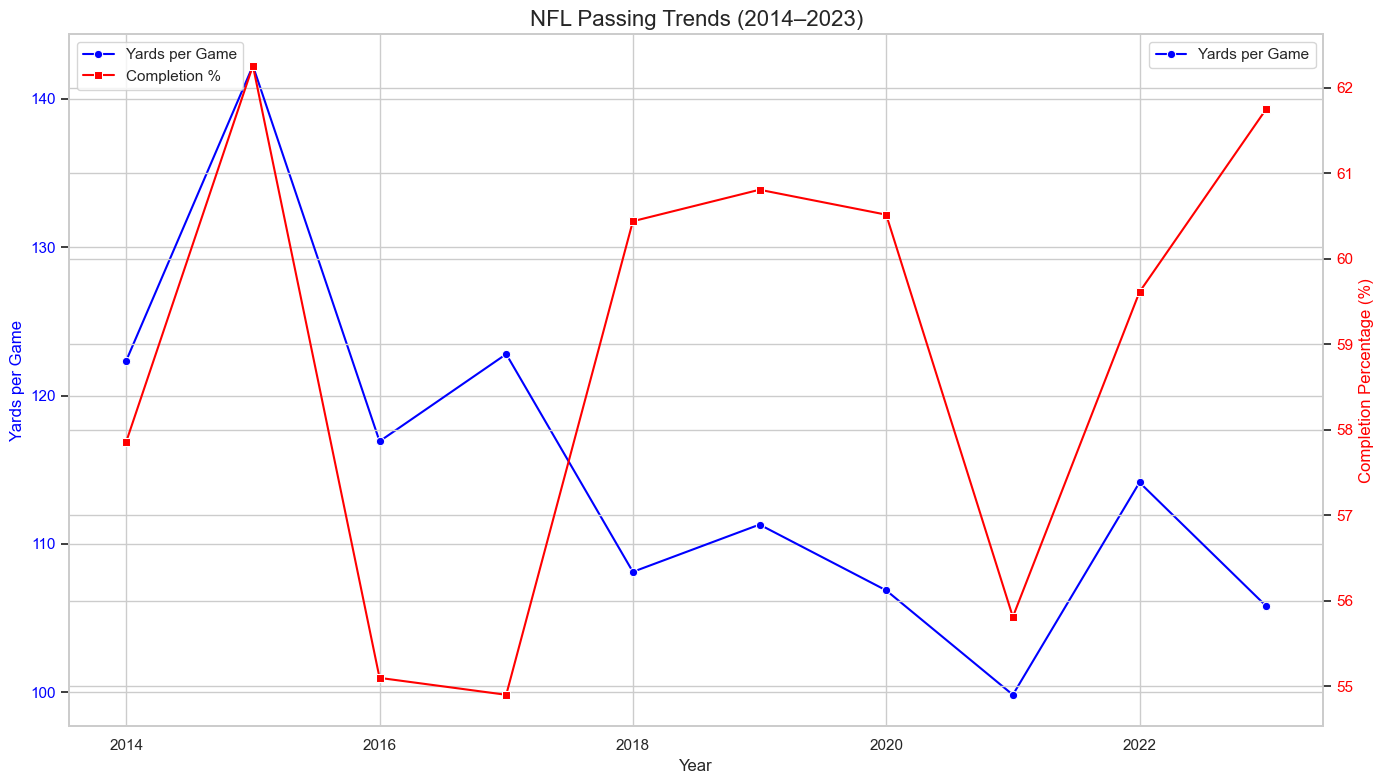

In [30]:
''' Visualization: '''
# Sets the visual style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

# Creates the main figure and first y-axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Yards per Game (blue line)
sns.lineplot(
    x='Year', 
    y='yards_per_game', 
    data=yearly_stats, 
    marker='o', 
    ax=ax1, 
    label='Yards per Game', 
    color='blue'
)
ax1.set_ylabel('Yards per Game', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creates a second y-axis for Completion Percentage (red line)
ax2 = ax1.twinx()
sns.lineplot(
    x='Year', 
    y='completion_pct', 
    data=yearly_stats, 
    marker='s', 
    ax=ax2, 
    label='Completion %', 
    color='red'
)
ax2.set_ylabel('Completion Percentage (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and X-axis label
plt.title('NFL Passing Trends (2014–2023)', fontsize=16)
ax1.set_xlabel('Year', fontsize=12)

# Combine both legends into one
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Final layout adjustment
plt.tight_layout()
plt.show()

### Visual Description and Interpretation
The graph above is a a graph that displays the trends in NFL quarterback passing stats from the 2014 season to the 2023 season.
   
   1. The Blue line shows the average passing yards per game in each season
   2. The red line representes the average completion percentage each season
   3. x-axis shows the season
   4. Left of y-axis shows yards per game while right is completion percentage

The chart shows a general downwards trend for yards per game over the years. As for completion percentage it trended upwards in: 2014 to 2015, 2017 to 2020, and 2021 to 2024. It trended downwards in: 2015 to 2017 and 2020 to 2021.